In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians, degrees, cos, sin, asin, sqrt

from scipy.stats import hmean

# from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm as tqdm_t

from tqdm._tqdm_notebook import tqdm_notebook as tqdm

import feather

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM, Dropout

from pathlib import Path

import utm

from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.ops import nearest_points

from multiprocessing import Pool

from matplotlib.colors import LogNorm

from sklearn.neighbors import KNeighborsRegressor

In [2]:
test_fraction = 4/5

In [3]:
# messages = pd.read_csv("../../Trapeze_Data/first dump/VehicleMessages.csv", dtype={"isValid":float, "workCode":float,"tripCode":float}, parse_dates=[1], infer_datetime_format=True)


In [4]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     "segment_duration",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "diff_segment_and_mean_by_segment_code",
                                     "diff_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'line_distance',
                                     'to_centre_dist',
                                     'direction_degrees',
                                     'rain',
                                     'median_durations_by_segment_code_and_hour_and_day',
                                     'arrival_hour','arrival_day',
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'date','workid',
                                     'actualArrival',
                                     'publicName',
                                     'segment_name',
                                     'prev_segment_code_1',
                                     'next_segment_code_1'
                                    ])
se = se.set_index(se.columns[0])

In [5]:
routes = pd.read_csv("../../Bournemouth GTFS/routes.csv")
shapes = pd.read_csv("../../Bournemouth GTFS/shapes.csv")
stops = pd.read_csv("../../Bournemouth GTFS/stops.txt").set_index('stop_id')
trips = pd.read_csv("../../Bournemouth GTFS/trips.txt")
performed_work = pd.read_csv("../../Trapeze_Data/first dump/PerformedWork.csv", parse_dates=[1])

In [214]:
se_gps_data_hour = np.load("se_gps_features_20min_80min_5.npy")
se_gps_data_20mins = np.load("se_gps_features_20min_40min_5.npy", )
se_gps_data_hour_prev_next = np.load("se_gps_features_20min_80min_prev_next_5.npy")

In [7]:
# se['speed_mph'] = se['line_distance']*1000/se['segment_duration'] * 2.237

# se['speed_mph_baseline'] = se['line_distance']*1000/se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

In [8]:
se['prev_segment_name'] = se['prev_segment_code_1'].str[:-2]
se['next_segment_name'] = se['next_segment_code_1'].str[:-2]

In [9]:
trips_to_shapes_dict = {}

for route_id, route_group in trips.groupby('route_id'):
    matching_shapes = route_group.groupby('shape_id').first().index.values
    
    trips_to_shapes_dict[route_id] = matching_shapes


In [10]:
shapes_dict = {}

for shape_name, shape in tqdm(shapes.groupby('shape_id')):
    
    coords = np.empty((len(shape)+1, 2))
    
    for i, row in enumerate(shape[['latitude','longitude']].itertuples()):

        coords[i, :] = utm.from_latlon(row[1], row[2])[:2]
                        
    shapes_dict[shape_name] = LineString(coords)

          

In [11]:
segment_cache = {}

def find_length_by_name_route(segment_name, route_id, line_dist):
    
    line_dist = line_dist * 1000
    
    if segment_name in segment_cache:
        return segment_cache[segment_name]
    
    if type(route_id) == float:
        if np.isnan(route_id):
            
            segment_cache[segment_name] = line_dist
            
            return line_dist
    
    best_dist = np.inf
    lengths = []
    distances = []
    
    stop_codes = segment_name.split('_')

    try:
        stop_1_point = Point(utm.from_latlon(*stops.loc[stop_codes[0]][['stop_lat', 'stop_lon']].values)[:2])

        stop_2_point = Point(utm.from_latlon(*stops.loc[stop_codes[1]][['stop_lat', 'stop_lon']].values)[:2])
    except KeyError:
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    for shape_name in trips_to_shapes_dict[route_id]:

        shape = shapes_dict[shape_name]
        
        nearest_1 = nearest_points(shape, stop_1_point)[0]
        nearest_2 = nearest_points(shape, stop_2_point)[0]

        combined_dist = stop_1_point.distance(nearest_1) + stop_2_point.distance(nearest_2)
            
#         distances.append(combined_dist)
#         lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))

        # Find the cases where the points are close to the shape
        if (combined_dist) <= best_dist:
            best_dist = combined_dist
            
            distances.append(combined_dist)
            lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))
                
    if(best_dist >= 15):
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    # Take the mean of only those shapes where the points is very close to the shape
    new_length = np.mean(np.asarray(lengths)[np.asarray(distances) == best_dist])
    
    if (new_length == 0) | (new_length > 4000):
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    segment_cache[segment_name] = new_length

    return segment_cache[segment_name]

In [12]:
se['route_id'] = routes.set_index('route_short_name').loc[se['publicName']]['route_id'].values


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [13]:
tqdm.pandas("My Bar")

In [14]:
se['real_length'] = se.progress_apply(lambda row: find_length_by_name_route(row['segment_name'], row['route_id'], row['line_distance']), axis=1)

In [15]:
se['speed_mph'] = se['real_length'] / se['segment_duration'] * 2.237

se['speed_mph_baseline'] = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

In [180]:
messages = pd.read_csv("messages_with_true_dist.csv")

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [181]:
messages['timeReported'] = pd.to_datetime(messages['timeReported'])

In [182]:
# messages['delta_time'] = messages['timeReported'] - messages.shift(1)['timeReported']
# messages['time_seconds'] = messages['delta_time'] / np.timedelta64(1, 's')

In [183]:
# messages['workCode'] = messages['workCode'].fillna(method="ffill")
# messages['tripCode'] = messages['tripCode'].fillna(method="ffill")

In [184]:
messages['dateReported'] = messages['timeReported'].dt.date

In [185]:
messages['dateReported'] = pd.to_datetime(messages['dateReported'])

In [22]:
# performed_work['tripCode'] = performed_work['tripCode'].replace([np.nan, np.inf], -1)

# performed_work['tripCode'] = performed_work['tripCode'].astype(int)

In [23]:
# messages = messages.reset_index().merge(performed_work[['workCode', 'tripCode', 'date', 'publicName']],
#                             left_on=['workCode', 'tripCode', 'dateReported'], 
#                             right_on=['workCode', 'tripCode', 'date'],
#                            how="left").set_index("index")

In [24]:
# messages = messages.reset_index().merge(routes[['route_short_name', 'route_id']], 
#                                         left_on=['publicName'], 
#                                         right_on=['route_short_name'], 
#                                         how="left").set_index("index")

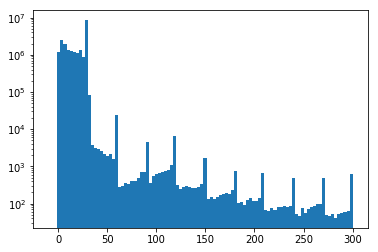

In [25]:
plt.hist((messages['time_seconds']).values, bins=100, range=(-10, 300));
plt.yscale("log")
plt.show()

In [26]:
print(f"Fraction under 31 seconds: {np.count_nonzero(messages['time_seconds'] < 31)/messages.shape[0]}")
      
print(f"Between 20 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 20))/messages.shape[0]}")
      
print(f"Between 10 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 10))/messages.shape[0]}")
      
print(f"Between 5 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 5))/messages.shape[0]}")
      

Fraction under 31 seconds: 0.9922119130009464
Between 20 and 31 seconds: 0.49658042452244816
Between 10 and 31 seconds: 0.6831238955905359
Between 5 and 31 seconds: 0.817413135029027


In [27]:
# messages['delta_lon'] = messages['lon'] - messages.shift(1)['lon']
# messages['delta_lat'] = messages['lat'] - messages.shift(1)['lat']

In [28]:
messages['msg'].unique()

array(['inPosition', 'InTripEnd', 'InTripStart', 'InPointArrive',
       'InPointDepart'], dtype=object)

In [29]:
# def haversine_np(lon1, lat1, lon2, lat2):
#     """
#     Calculate the great circle distance between two points
#     on the earth (specified in decimal degrees)

#     All args must be of equal length.    

#     """
#     lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

#     dlon = lon2 - lon1
#     dlat = lat2 - lat1

#     a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

#     c = 2 * np.arcsin(np.sqrt(a))
#     km = 6367 * c
#     return km

In [30]:
# messages['delta_distance'] = haversine_np(messages['lon'], messages['lat'], messages['lon'].shift(1), messages['lat'].shift(1)) * 1000


In [31]:
# messages = messages.dropna(subset=['lon', 'lat'])

# messages = messages[(messages['time_seconds'] > 0)]

In [32]:
# messages['lon_next'] = messages['lon'].shift(1)
# messages['lat_next'] = messages['lat'].shift(1)


In [33]:
# num_partitions = 20
# num_cores = 5

# def parallelize_dataframe(df, func, args):
#     df_split = np.array_split(df, num_partitions)
#     pool = Pool(num_cores)
    
#     # This line is fidly, we make a list where each item is a tuple of 
#     # a bit of the dataframe and whatever is passed in as args. 
#     # Then starmap unpacks that tuple so each copy of func gets it's 
#     # little bit of the dataframe and the right args to do it's job. 
#     # All this to avoid globals! 
#     all_args = [(split,) + args for split in df_split]
    
#     df = pd.concat(pool.starmap(func, all_args))
#     pool.close()
#     pool.join()
#     return df

In [34]:
# messages.iloc[1510485]


In [35]:
# def find_dist(messages):

#     messages['true_distance'] = messages[['lon', 'lat', 
#                                           'lon_next', 'lat_next', 
#                                           'route_id', 'delta_distance'
#                                          ]].apply(lambda row: find_length_by_geo_route(*row[['lat', 'lon',
#                                                                                           'lat_next', 
#                                                                                            'lon_next',
#                                                                                            'route_id',
#                                                                                            'delta_distance'
#                                                                                           ]]), axis=1)

#     return messages



In [36]:
# messages = parallelize_dataframe(messages, find_dist, ())

In [37]:
# messages['delta_speed'] = messages['true_distance']/messages['time_seconds']

In [38]:
# messages['speed_mph'] = messages['delta_speed'] * 2.237

In [39]:
# messages.to_csv("messages_with_true_dist.csv")



In [40]:
# messages.to_csv("messages_with_true_dist.csv")

In [187]:
print(f"total: {len(messages)}")

print(f"changed: {np.count_nonzero(messages['true_distance'] != messages['delta_distance'])}")
      
print(f"is close: {np.count_nonzero(np.isclose(messages['true_distance'], messages['delta_distance']))}")

total: 21434532
changed: 5660938
is close: 15777464


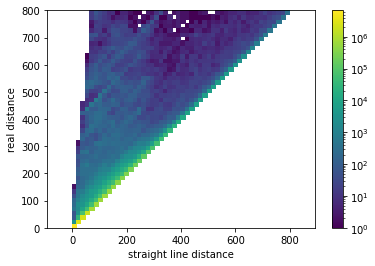

In [186]:
plt.hist2d(messages['delta_distance'], messages['true_distance'], bins=[50,50], range=[[0,800],[0,800]], norm=LogNorm())
plt.axis('equal')
plt.xlabel("straight line distance")
plt.ylabel("real distance")
plt.colorbar()

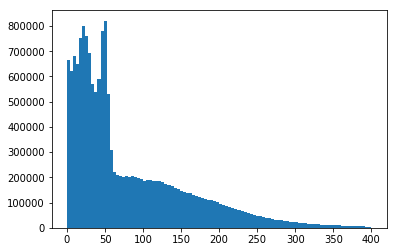

In [188]:
plt.hist(messages['true_distance'], bins=100, range=(0.1,400));

In [189]:
(np.count_nonzero(messages['delta_distance']*0.5 >= messages['true_distance'])/len(messages))*100

19.3412060501251

total: 3920087
changed: 2773628
is close: 1146459


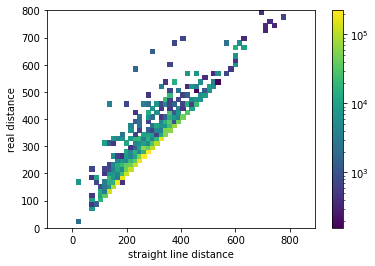

In [190]:
print(f"total: {len(se)}")

print(f"changed: {np.count_nonzero(se['real_length'] != se['line_distance']*1000)}")
      
print(f"is close: {np.count_nonzero(np.isclose(se['real_length'], se['line_distance']*1000))}")

plt.hist2d(se['line_distance']*1000, se['real_length'], bins=[50,50], range=[[0,800],[0,800]], norm=LogNorm())
plt.axis('equal')
plt.xlabel("straight line distance")
plt.ylabel("real distance")
plt.colorbar()

In [45]:
# plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400));
# plt.yscale("log")

In [46]:
# plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400));
# plt.yscale("log")

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


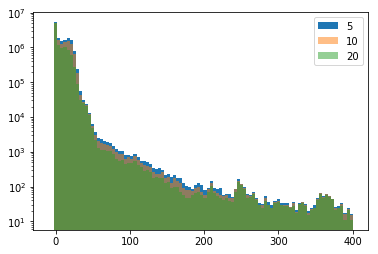

In [47]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400), label="5");
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 10)]['speed_mph'], bins=100, range=(-10,400), label="10", alpha=0.5);
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400), label="20", alpha=0.5);
plt.yscale("log")
plt.legend()

In [191]:
messages['prev_speed_mph'] = messages.shift(1)['speed_mph']
messages['next_speed_mph'] = messages.shift(-1)['speed_mph']

In [192]:
messages['jitter'] = [False]*messages.shape[0]

messages['jitter'] = (messages['speed_mph'] > 75) & \
    (((messages['prev_speed_mph'] > 75) & (messages['next_speed_mph'] < 50)) | \
     ((messages['next_speed_mph'] > 75) & (messages['prev_speed_mph'] < 50)))

In [193]:
filtered = messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5) & (messages['jitter'] == False) & (messages['speed_mph'] != np.inf)]


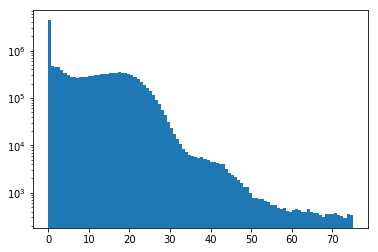

In [194]:
plt.hist(filtered['speed_mph'], bins=100, range=(0,75));
plt.yscale("log")

In [195]:
filtered['segment_name'] = filtered['stopCode'].fillna(method="ffill") + "_" + filtered['stopCode'].fillna(method="bfill") 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [196]:
se['speed_mph'] = se['real_length']/se['segment_duration'] * 2.237

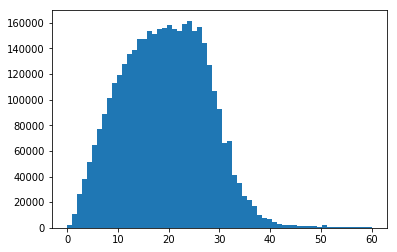

In [197]:
plt.hist(se['speed_mph'], range=(0, 60), bins=61);

In [198]:
se['mean_speed_mph_by_segment_code_hour_day'] = se['real_length']/se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

In [215]:
def prep_training_data(data, target, cut_point, scale=True):

#     cut_point = int(len(data)*test_fraction)
    
    train_data = data[:cut_point,:].copy()
    test_data = data[cut_point:,:].copy()
    
    test_mask = np.zeros(data.shape[0]).astype(bool)
    test_mask[cut_point:] = True

    train_target = target[:cut_point].copy()
    test_target = target[cut_point:].copy()
    
    if scale == False:
        return train_data, test_data, train_target, test_target
    
    scaler_target = preprocessing.StandardScaler().fit(train_target[:, None])

#     scaler_target = preprocessing.MinMaxScaler().fit(train_target[:, None])


    train_target_scaled = scaler_target.transform(train_target[:, None]).astype(np.float32)
    test_target_scaled = scaler_target.transform(test_target[:, None]).astype(np.float32)
    
    data_scaler = preprocessing.StandardScaler()

    train_data_scaled = data_scaler.fit_transform(train_data).squeeze()
    test_data_scaled = data_scaler.transform(test_data).squeeze()

    return train_data_scaled, test_data_scaled, train_target_scaled, test_target_scaled, scaler_target


In [216]:
se.columns

Index(['date', 'actualArrival', 'workid', 'publicName', 'segment_name',
       'line_distance', 'to_centre_dist', 'direction_degrees', 'rain',
       'segment_duration', 'arrival_hour', 'arrival_day',
       'mean_durations_by_segment_code_and_hour_and_day',
       'median_durations_by_segment_code_and_hour_and_day',
       'prev_segment_code_1', 'next_segment_code_1',
       'diff_segment_and_mean_by_segment_code_and_hour_and_day',
       'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day',
       'prev_segment_name', 'next_segment_name', 'route_id', 'real_length',
       'speed_mph', 'speed_mph_baseline',
       'mean_speed_mph_by_segment_code_hour_day'],
      dtype='object')

In [253]:
segment_names = se[se_gps_data_hour_prev_next[:,7] >= 10].groupby('segment_name').count().sort_values('date', ascending=False)

In [254]:
over4k_names = segment_names[segment_names['date'] > 2000]

In [255]:
len(over4k_names)

324

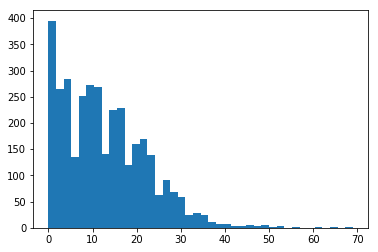

In [256]:
just_top_gps = se_gps_data_hour_prev_next[se['segment_name'] == over4k_names.index[-1]]

plt.hist(just_top_gps[:,7], bins=40);

In [257]:
se_gps_data_hour_prev_next[np.isnan(se_gps_data_hour_prev_next)] = 0 
se['speed_mph'] = se['speed_mph'].replace(np.inf, 0)


In [270]:
poly = PolynomialFeatures()

lr_dict = {}
scaler_target_dict = {}
scaler_data_dict = {}

cut_point = int(len(se)*test_fraction)

train_se = se[:cut_point]
train_se_gps = se_gps_data_hour_prev_next[:cut_point]

mask = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

for name in tqdm(over4k_names.index):
    just_top_gps = train_se_gps[train_se['segment_name'] == name, 1:]
    just_top_se = train_se[train_se['segment_name'] == name]
    
    just_top_se = just_top_se[just_top_gps[:,6] >= 10]
    just_top_gps = just_top_gps[just_top_gps[:,6] >= 10]
    
    lr = Ridge()

#     scal_data = preprocessing.StandardScaler()
    
#     scal_target = preprocessing.StandardScaler()
    
#     scal_data.fit_transform(just_top_gps)
    
#     svr = SVR(max_iter=1000)

    lr.fit(poly.fit_transform(just_top_gps[:,mask == 1]), just_top_se['speed_mph'])

#     svr.fit(scal_data.fit_transform(just_top_gps), scal_target.fit_transform(just_top_se['speed_mph'].values.reshape(-1, 1)).squeeze())
    
    lr_dict[name] = lr
    
#     scaler_data_dict[name] = scal_data
#     scaler_target_dict[name] = scal_target
    
    


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.694882e-13
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.368844e-14
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.684091e-12
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.049171e-12
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.112923e-11
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.424761e-10
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.207937e-10
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.634865e-11
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.634736e-11
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.640571e-15
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.384957e-14
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.520074e-14
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.759328e-12
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.423974e-10
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.341004e-10
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.405274e-10
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.032315e-10
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.649006e-12
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.730982e-09
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.495502e-09
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.530479e-09
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.750993e-10
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.032528e-10
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.974651e-11
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.073729e-14
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.371901e-09
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.865589e-11
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.427427e-09
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.019913e-09
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.762193e-09
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.732429e-14
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.265815e-09
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.422719e-08
  overwrite_a=True).T
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is n

In [271]:
test_se = se[cut_point:].copy()
test_se_gps = se_gps_data_hour_prev_next[cut_point:]

test_se['pred'] = test_se['real_length'] / test_se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

test_se = test_se.reset_index()

for seg_name, seg in tqdm(test_se[['segment_name']].groupby('segment_name')):
    if seg_name in lr_dict:
        
        seg = seg[test_se_gps[seg.index, 7] >= 10]
        test_se.loc[seg.index, 'pred'] = lr_dict[seg_name].predict(poly.fit_transform(test_se_gps[seg.index, 1:][:,mask == 1]))
#         test_se.loc[seg.index, 'pred'] = scaler_target_dict[seg_name].inverse_transform(lr_dict[seg_name].predict(scaler_data_dict[seg_name].transform(test_se_gps[seg.index, 1:])))

In [272]:
print(f"RMSE pred: {np.sqrt(mean_squared_error(test_se['speed_mph'], test_se['pred']))}")
print(f"RMSE base: {np.sqrt(mean_squared_error(test_se['speed_mph'], test_se['real_length'] / test_se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237))}")
print(f"RMSE base_median: {np.sqrt(mean_squared_error(test_se['speed_mph'], test_se['real_length'] / test_se['median_durations_by_segment_code_and_hour_and_day'] * 2.237))}")

print(f"MAE pred: {mean_absolute_error(test_se['speed_mph'], test_se['pred'])}")
print(f"MAE base: {mean_absolute_error(test_se['speed_mph'], test_se['real_length'] / test_se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)}")
print(f"MAE base_median: {mean_absolute_error(test_se['speed_mph'], test_se['real_length'] / test_se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)}")


RMSE pred: 11.423751414830155
RMSE base: 11.622504586790907
RMSE base_median: 11.266602931466238
MAE pred: 4.956844114186245
MAE base: 5.137757484460484
MAE base_median: 4.60521725712747


In [265]:
(baseline_array_cum, 
     actual_array_cum, 
     baseline_median_array_cum, 
     baseline_pass_count, 
     pass_fraction, 
     baseline_median_pass_count, 
     median_pass_fraction) = calc_baseline_and_actual(test_se)

predict_array_linear_cum, _, pass_fraction = calc_prediction_cum_journeys(test_se, test_se['pred'], baseline_median_array_cum, actual_array_cum)


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -9.86% improvment on baseline
Approximately 37.10% are in 10%


In [266]:
predict_array_linear_cum, _, pass_fraction = calc_prediction_cum_journeys(test_se, test_se['pred'], baseline_array_cum, actual_array_cum)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -5.24% improvment on baseline
Approximately 37.10% are in 10%



..............................................................................
..............................................................................
..............................................................................
..............................................................................

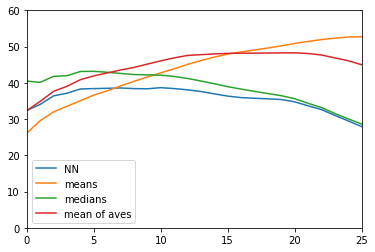

In [210]:
plt.plot(make_accuracy_matrix_minutes(predict_array_linear_cum, actual_array_cum)[0][0,:], label="NN")
plt.plot(make_accuracy_matrix_minutes(baseline_array_cum, actual_array_cum)[0][0,:], label="means")
plt.plot(make_accuracy_matrix_minutes(baseline_median_array_cum, actual_array_cum)[0][0,:], label="medians")
plt.plot(make_accuracy_matrix_minutes((baseline_median_array_cum + baseline_array_cum)/2, actual_array_cum)[0][0,:], label="mean of aves")
plt.xlim(0,25)
plt.ylim(0,60)
plt.legend()
plt.show()

In [89]:
just_top_gps = se_gps_data_hour_prev_next[se['segment_name'] == '1290BOB20412_1290BOB20410']
just_top_se = se[se['segment_name'] == '1290BOB20412_1290BOB20410']

data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
                                                            'direction_degrees', 
                                                            "to_centre_dist",
                                                           'rain',
                                                           'arrival_hour',
                                                           'arrival_day']].values))

data = data[se['segment_name'] == '1290BOB20412_1290BOB20410']

In [90]:
print(f"percent invalid just_top_gps: {np.count_nonzero(np.isnan(just_top_gps) |~np.isfinite(just_top_gps))/just_top_gps.size*100}")
print(f"percent invalid just_top_se['speed_mph']: {np.count_nonzero(np.isnan(just_top_se['speed_mph']) |~np.isfinite(just_top_se['speed_mph']))/just_top_se['speed_mph'].size*100}")
print(f"percent invalid just_top_se['speed_mph']: {np.count_nonzero(np.isnan(data) |~np.isfinite(data))/data.size*100}")


percent invalid just_top_gps: 0.003697968428594541
percent invalid just_top_se['speed_mph']: 0.03697968428594541
percent invalid just_top_se['speed_mph']: 0.0027734763214459055


In [91]:
just_top_gps[np.isnan(just_top_gps)] = 0
data[np.isnan(data)] = 0
just_top_se['speed_mph'] = just_top_se['speed_mph'].replace(np.inf, 0)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


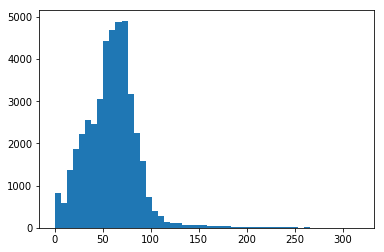

In [92]:
plt.hist(just_top_gps[:,7], bins=50);

In [93]:
cut_point = int(len(just_top_se)*test_fraction)

In [94]:
(baseline_array_cum, 
     actual_array_cum, 
     baseline_median_array_cum, 
     baseline_pass_count, 
     pass_fraction, 
     baseline_median_pass_count, 
     median_pass_fraction) = calc_baseline_and_actual(just_top_se[cut_point:])

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


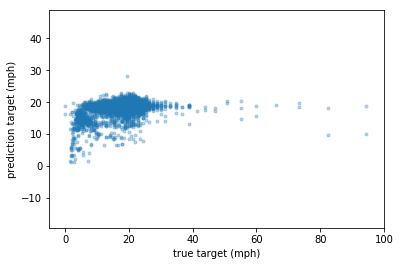

RMSE pred: 9.43705301343163
RMSE base: 9.446064955216961
MAE pred: 3.5187759850359974
MAE base: 3.6656332365995086


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately 8.38% improvment on baseline
Approximately 38.87% are in 10%


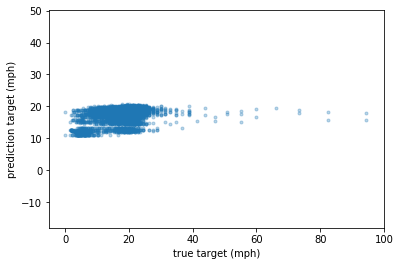

In [95]:
poly = PolynomialFeatures()

# (train_data_scaled, test_data_scaled, 
#  train_target_scaled, test_target_scaled, 
#  scaler_target) = prep_training_data(poly.fit_transform(just_top_gps), just_top_se['speed_mph'].values, cut_point)

(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled) = prep_training_data(poly.fit_transform(just_top_gps), just_top_se['speed_mph'].values, cut_point, False)

test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

lr = LinearRegression()
ar = ARDRegression()
# lr = Lasso()

lr.fit(train_data_scaled, train_target_scaled)

test_y_scaled = lr.predict(test_data_scaled)

# test_y = scaler_target.inverse_transform(test_y_scaled).squeeze()

test_y = test_y_scaled

# test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

test_target_truth = test_target_scaled

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.axis("equal")
plt.xlim(-5,100)
plt.show()

plt.scatter(test_target_truth, just_top_se[cut_point:]['real_length'] / just_top_se[cut_point:]['mean_durations_by_segment_code_and_hour_and_day'] * 2.237, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.axis("equal")
plt.xlim(-5,100)

print(f"RMSE pred: {np.sqrt(mean_squared_error(test_target_truth, test_y))}")
print(f"RMSE base: {np.sqrt(mean_squared_error(test_target_truth, just_top_se[cut_point:]['real_length'] / just_top_se[cut_point:]['mean_durations_by_segment_code_and_hour_and_day'] * 2.237))}")

print(f"MAE pred: {mean_absolute_error(test_target_truth, test_y)}")
print(f"MAE base: {mean_absolute_error(test_target_truth, just_top_se[cut_point:]['real_length'] / just_top_se[cut_point:]['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)}")

predict_array_linear_cum, _, pass_fraction = calc_prediction_cum_journeys(just_top_se[cut_point:], test_y, baseline_array_cum, actual_array_cum)




......
......
......
......

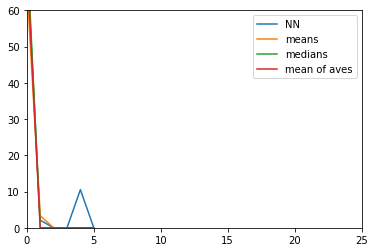

In [96]:
plt.plot(make_accuracy_matrix_minutes(predict_array_NN_cum, actual_array_cum)[0][1,:], label="NN")
plt.plot(make_accuracy_matrix_minutes(baseline_array_cum, actual_array_cum)[0][1,:], label="means")
plt.plot(make_accuracy_matrix_minutes(baseline_median_array_cum, actual_array_cum)[0][1,:], label="medians")
plt.plot(make_accuracy_matrix_minutes((baseline_median_array_cum + baseline_array_cum)/2, actual_array_cum)[0][1,:], label="mean of aves")
plt.xlim(0,25)
plt.ylim(0,60)
plt.legend()
plt.show()

In [ ]:
ordered_names = np.array(names).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

ordered_coef = np.array(lr.coef_).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

display(list(zip(ordered_names, ordered_coef))[::-1])

In [ ]:
def create_simple_model(input_shape, dropout, NN, use_linear):

    # with help from: https://keras.io/getting-started/functional-api-guide/

    # Headline input: meant to receive road time series.
    main_input = Input(shape=[input_shape], dtype="float32", name="input")

    for index, layer in enumerate(NN):
        if(index == 0):
            x = Dense(layer, activation="relu")(main_input)
            x = Dropout(rate=dropout)(x)
        else:
            x = Dense(layer, activation="relu")(x)
            x = Dropout(rate=dropout)(x)

#     # We stack a deep densely-connected network on top
#     x = Dense(128, activation="relu")(main_input)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(64, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(32, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(32, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(12, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)

    # And finally we add the main output layer
    if use_linear:
        main_output = Dense(1, activation="linear", name="main_output")(x)
    else: 
        main_output = Dense(1, activation="tanh", name="main_output")(x)

    model = Model(
        inputs=[main_input], outputs=[main_output]
    )

    model.summary()

    return model

In [ ]:
data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
                                                            'direction_degrees', 
                                                            "to_centre_dist",
                                                           'rain',
                                                           'arrival_hour',
                                                           'arrival_day']].values))

df_cors = pd.DataFrame(data=np.hstack((data, se[['speed_mph']].values)),
                    columns=['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                'clipped_hmean','clipped_mean','freq_total',
                                'freq_fast','freq_clipped', 
                               'fast_median', 'fast_75th percential',
                              'total_median', 'total_75th percential', 'max', 
                             'real_length', 'direction_degrees', "to_centre_dist",
                                                           'rain',
                                                           'arrival_hour',
                                                           'arrival_day','true_speed'])

cors = df_cors[df_cors['freq_fast'] >= 10].corr()

In [ ]:
cors

In [ ]:
# For version 3

cors['true_speed'].abs().sort_values().index[::-1]

In [ ]:
plt.hist(se_gps_data_hour_prev_next[:,1], bins=50, range=(0,1));

In [ ]:
plt.hist(se_gps_data_hour_prev_next[:,4], bins=50, range=(0,50));

In [ ]:
plt.hist(se_gps_data_hour_prev_next[:,13], bins=50, range=(0,50));

In [ ]:
plt.hist(se['speed_mph'], bins=50, range=(0,50));

In [ ]:
plt.hist2d(se['speed_mph'], se_gps_data_hour_prev_next[:,13], range=[[0,50],[0,30]], bins=[50,50]);
plt.axis('equal')

In [ ]:
plt.hist(filtered['speed_mph'], bins=50, range=(3,50));

In [ ]:
def make_valid_mask(freq):

    valid_mask = (se_gps_data_hour_prev_next[:,9] >= freq) & \
    (se['speed_mph'] != np.inf) & \
    (~np.isnan(se_gps_data_hour_prev_next[:,4])) & \
    (~np.isnan(se_gps_data_hour_prev_next[:,10])) & \
    (se_gps_data_hour_prev_next[:,13] != 0)
    
    return valid_mask

In [ ]:
# def do_baselines(valid_mask):
#     (baseline_array_cum, 
#      actual_array_cum, 
#      baseline_median_array_cum, 
#      baseline_pass_count, 
#      pass_fraction, 
#      baseline_median_pass_count, 
#      median_pass_fraction) =  calc_baseline_and_actual(se[int(len(se)*test_fraction):])

#     return (baseline_array_cum, 
#          actual_array_cum, 
#          baseline_median_array_cum, 
#          baseline_pass_count, 
#          pass_fraction, 
#          baseline_median_pass_count, 
#          median_pass_fraction)

# calc_baseline_and_actual

In [ ]:
# 0 slow_fraction
# 1 fast_hmean
# 2 fast_mean
# 3 total_mean
# 4 clipped_hmean
# 5 clipped_mean
# 6 freq_total
# 7 freq_fast
# 8 freq_clipped
# 9 fast_median
# 10 fast_75th percential
# 11 total_median
# 12 total_75th percential
# 13 max

overlaps_dict = {}
overlaps_dict[0] = []
overlaps_dict[1] = [4, 5, 11, 9, 12]
overlaps_dict[2] = [3, 10, 9]
overlaps_dict[3] = [2, 10, 12]
overlaps_dict[4] = [1, 5]
overlaps_dict[5] = [1, 4]
overlaps_dict[6] = [7, 8]
overlaps_dict[7] = [6, 8]
overlaps_dict[8] = [6, 7]
overlaps_dict[9] = [1, 2, 10, 12]
overlaps_dict[10] = [2, 9, 3]
overlaps_dict[11] = [1, 12]
overlaps_dict[12] = [1, 3, 9, 11]
overlaps_dict[13] = []
overlaps_dict[14] = []
overlaps_dict[15] = []


In [ ]:
def make_overlap_mask(width = 16):
    overlaps_mask = np.zeros(width)

    overlaps_mask[:] = -1
    
    overlaps_mask[11] = 1 # 11 total_median
    overlaps_mask[4] = 1 # 4 clipped_hmean
    overlaps_mask[3] = 1 # 3 total_mean
    
    while(np.isin([-1], overlaps_mask).any()):
        options = np.where(overlaps_mask < 0)[0]
    #     print(options)
        i = np.random.randint(len(options))
#         print(i)
        overlaps_mask[options[i]] = 1
        overlaps_mask[overlaps_dict[options[i]]] = 0

    return overlaps_mask.astype(bool)
    


In [ ]:
def best_overlap_mask(freq, data, columns):
    
#     data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
#                                                             'direction_degrees', 
#                                                             "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day']].values))

    df_cors = pd.DataFrame(data=np.hstack((data, se[['speed_mph']].values)),
                        columns=columns)

    cors = df_cors[df_cors['freq_fast'] >= freq].corr()
    
    overlaps_dict = {}

    abs_cor_top_75th = np.percentile(np.abs(cors.values), 75)

    for col_idx, column in enumerate(cors.columns):

        if column == 'true_speed':
            continue

        overlaps_dict[column] = []

        for row_idx, (name, value) in enumerate(cors[column].iteritems()):
            if np.abs(value) > abs_cor_top_75th and column != name:
    #             print(f"{column} -> {name}: {value}")
                overlaps_dict[column].append(row_idx)
        
    overlap_mask = np.empty(len(cors['true_speed']))

    overlap_mask[:] = -1

    for best in cors['true_speed'].abs().sort_values().index[::-1]:

        if(best == "true_speed"):
            continue

        best_idx = cors.columns.get_loc(best)

        if overlap_mask[best_idx] == -1:
            overlap_mask[best_idx] = 1
            overlap_mask[overlaps_dict[best]] = 0


    return overlap_mask[:-1]

In [ ]:
train_speeds = se['speed_mph'][:int(len(se)*test_fraction)]

mean_speed = np.mean(train_speeds[np.isfinite(train_speeds)])
print(mean_speed)

In [ ]:
(baseline_array_cum, 
     actual_array_cum, 
     baseline_median_array_cum, 
     baseline_pass_count, 
     pass_fraction, 
     baseline_median_pass_count, 
     median_pass_fraction) = calc_baseline_and_actual(se[int(len(se)*test_fraction):])

In [ ]:
def learn(freq, dropout, loss, NN, use_linear = False):
    
    valid_mask = make_valid_mask(freq)
    
#     data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
#                                                             'direction_degrees', 
#                                                             "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day'
#                                                            ]].values))

#     overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
#                                     'clipped_hmean','clipped_mean','freq_total',
#                                     'freq_fast','freq_clipped', 
#                                    'fast_median', 'fast_75th percential',
#                                   'total_median', 'total_75th percential', 'max', 
#                                  'real_length', 'direction_degrees', "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day','true_speed'])


    data = se_gps_data_hour_prev_next[:,1:]

    overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                    'clipped_hmean','clipped_mean','freq_total',
                                    'freq_fast','freq_clipped', 
                                   'fast_median', 'fast_75th percential',
                                  'total_median', 'total_75th percential', 'max', 
                                    'true_speed'])

    
    # where on the reduced (valid mask) data is the right place to cut so that when it comes back
    # it's exactly test_fraction from the start
    cut_point_valid = np.count_nonzero(valid_mask[:int(len(se)*test_fraction)])
    
#     speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237
    
#     (train_data_scaled, test_data_scaled, 
#      train_target_scaled_baseline, test_target_scaled_baseline, 
#      scaler_target_baseline) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], speeds_mph_simple[valid_mask], cut_point_valid)


    (train_data_scaled, test_data_scaled, 
     train_target_scaled, test_target_scaled, 
     scaler_target) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], se[valid_mask]['speed_mph'], cut_point_valid)

    print(overlaps_mask)
    
    model = create_simple_model(
            (train_data_scaled.shape[1]),
            dropout, NN, use_linear)

    Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"GPS_models/freq_{freq}_mask_{overlaps_mask}_simple_[{'_'.join(list(map(str, NN)))}]_{loss}_{dropout}_{use_linear}.h5",
            monitor="val_loss",
            save_best_only=True,
        ),
    ]

    # model.compile(optimizer="rmsprop", loss="mean_absolute_error")
#     model.compile(optimizer="rmsprop", loss="logcosh")
    model.compile(optimizer="rmsprop", loss=loss)
    model.fit(
        train_data_scaled,
        train_target_scaled,
        epochs=100,
        callbacks=callbacks_list,
        batch_size=256,
        validation_data=(test_data_scaled, test_target_scaled),
    )

    test_y_scaled = model.predict(test_data_scaled)

    test_y = (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]

    test_y[valid_mask[int(len(se)*test_fraction):]] = scaler_target.inverse_transform(test_y_scaled)
    
    test_target_truth = se['speed_mph'][int(len(se)*test_fraction):]
    
    test_target_truth[~np.isfinite(test_target_truth)] = mean_speed

    RMSE = np.sqrt(mean_squared_error(test_target_truth, test_y))
    
    MAE = mean_absolute_error(test_target_truth, test_y)
    
    predict_array_NN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[int(len(se)*test_fraction):], test_y, baseline_array_cum, actual_array_cum)

    return overlaps_mask, pass_fraction, RMSE, MAE, test_y, predict_array_NN_cum

In [ ]:
def learn_KNN(freq=10, k=5):
    
    valid_mask = make_valid_mask(freq)
    
    data = se_gps_data_hour_prev_next[:,1:]

    overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                    'clipped_hmean','clipped_mean','freq_total',
                                    'freq_fast','freq_clipped', 
                                   'fast_median', 'fast_75th percential',
                                  'total_median', 'total_75th percential', 'max', 
                                    'true_speed'])

    
    # where on the reduced (valid mask) data is the right place to cut so that when it comes back
    # it's exactly test_fraction from the start
    cut_point_valid = np.count_nonzero(valid_mask[:int(len(se)*test_fraction)])
    
#     speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237
    
#     (train_data_scaled, test_data_scaled, 
#      train_target_scaled_baseline, test_target_scaled_baseline, 
#      scaler_target_baseline) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], speeds_mph_simple[valid_mask], cut_point_valid)


    (train_data_scaled, test_data_scaled, 
     train_target_scaled, test_target_scaled, 
     scaler_target) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], se[valid_mask]['speed_mph'], cut_point_valid)

    neigh = KNeighborsRegressor(n_neighbors=k, weights="distance")
    neigh.fit(train_data_scaled, train_target_scaled) 

    test_y_scaled = neigh.predict(test_data_scaled)

    test_y = (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]

    test_y[valid_mask[int(len(se)*test_fraction):]] = scaler_target.inverse_transform(test_y_scaled)
    
    test_target_truth = se['speed_mph'][int(len(se)*test_fraction):]
    
    test_target_truth[~np.isfinite(test_target_truth)] = mean_speed

    RMSE = np.sqrt(mean_squared_error(test_target_truth, test_y))
    
    MAE = mean_absolute_error(test_target_truth, test_y)
    
    predict_array_NN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[int(len(se)*test_fraction):], test_y, baseline_array_cum, actual_array_cum)

    return overlaps_mask, pass_fraction, RMSE, MAE, test_y, predict_array_NN_cum

In [ ]:
_, _, _, _, test_y, predict_array_KNN_cum = learn_KNN(10, 10)

In [ ]:
_, _, _, _, test_y, predict_array_NN_cum = learn(10, 0.0, "logcosh", [64,32,12], False)

# Draw real vs streight length for messages - Yes
# Try using straight lengths for the messages instead - Bad
# Try using a linear instead of tanh activation for the last layer - Worse
# Try predicting the mean and then still testing against true, for various networks
# Try to find one bus route where this works really well

In [ ]:
with open("GPS_run_3.csv", "a+") as f: 
    f.write("freq_threshold,dropout,loss,overlap_mask,NN,use_linear,pass_fraction,RMSE,MAE\n")
    for runs in range(5):
        for dropout in [0,0.2,0.5]:
            for loss in ['logcosh', 'mean_absolute_error', 'mean_squared_error']:
                for NN in [[64,32,12]]: #[[32,12,6], [64,32,12], [128,64,32,32,12]]:
                    for freq in [3,10,15,25]:
                        for use_linear in [True, False]:
                    
                            overlaps_mask, pass_fraction, RMSE, MAE, test_y = learn(freq, dropout, loss, NN, use_linear)
                            f.write(f"{freq},{dropout},{loss},{'_'.join(list(map(str,overlaps_mask)))},{'_'.join(list(map(str,NN)))},{use_linear},{pass_fraction},{RMSE},{MAE}\n")
                            f.flush()

In [ ]:
plt.plot(make_accuracy_matrix_minutes(predict_array_KNN_cum, actual_array_cum)[0][1,:], label="NN")
plt.plot(make_accuracy_matrix_minutes(baseline_array_cum, actual_array_cum)[0][1,:], label="means")
plt.plot(make_accuracy_matrix_minutes(baseline_median_array_cum, actual_array_cum)[0][1,:], label="medians")
plt.plot(make_accuracy_matrix_minutes((baseline_median_array_cum + baseline_array_cum)/2, actual_array_cum)[0][1,:], label="mean of aves")
plt.xlim(0,25)
plt.legend()
plt.show()

In [ ]:
plt.hist(test_y, bins=100, label="pred", density=True, range=(-10,100));
plt.hist(se['speed_mph'][int(len(se)*test_fraction):], bins=100, label="truth", alpha=0.5, density=True, range=(-10,100));
plt.legend()

In [ ]:
speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

se_min = se[['speed_mph', 'publicName', 'to_centre_dist', 'real_length', 'mean_durations_by_segment_code_and_hour_and_day']][int(len(se)*test_fraction):].copy()

se_min['baseline_speed'] = se_min['real_length'] / se_min['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

se_min['test_y'] = test_y

routes = []
pred_MSE = []
pred_RMSE = []
base_MSE = []
base_RMSE = []
freq = []
mean_dist = []

for route_name, route in se_min.groupby('publicName'):
    
    if route_name in schools:
        continue
        
    routes.append(route_name)
    pred_MSE.append(mean_absolute_error(route['speed_mph'], route['test_y']))
    pred_RMSE.append(np.sqrt(mean_squared_error(route['speed_mph'], route['test_y'])))
    base_MSE.append(mean_absolute_error(route['speed_mph'], route['baseline_speed']))
    base_RMSE.append(np.sqrt(mean_squared_error(route['speed_mph'], route['baseline_speed'])))
    freq.append(len(route))
    
results = pd.DataFrame(index=routes)
results['pred_MSE'] = pred_MSE
results['base_MSE'] = base_MSE
results['pred_RMSE'] = pred_RMSE
results['base_RMSE'] = base_RMSE
results['freq'] = freq

In [ ]:
results.sort_values('pred_RMSE')

In [ ]:
schools = ['46', '50', '60', '81', '85', '86', '87', '87A', '88', '111']

In [ ]:
np.count_nonzero(se['publicName'].isin(schools))

In [ ]:
# test_target_truth = se['speed_mph'][int(len(se[valid_mask])*test_fraction):]

test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.hist2d(test_target_truth, test_y.squeeze(), range=[[0,30],[0,30]], bins=[30,30])
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)
plt.axis('equal')

In [ ]:
predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[valid_mask][int(len(se[valid_mask])*test_fraction):], test_y.squeeze(), baseline_array_cum, actual_array_cum)
  

In [68]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0, 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))
    
    print("")

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [69]:
# From: https://stackoverflow.com/questions/51597849/padding-a-numpy-array-with-offsets-for-each-data-column

def create_padded_array(a, row_start, n_rows):
    r = np.arange(n_rows)[:,None]
    row_start = np.asarray(row_start)
    mask = (r >= row_start) & (r < row_start+a.shape[0])

    out = np.zeros(mask.shape, dtype=a.dtype)
    out[:] = np.nan
    out.T[mask.T] = a.ravel('F')
    return out   

def create_triangle(input_array, max_width=70):
    
    filled_values = np.empty((input_array.shape[0],70)).astype(float)
    
    filled_values[:] = input_array[:,None]
    
    return create_padded_array(filled_values, list(range(70)), input_array.shape[0]+71)[:input_array.shape[0],:]
    
    
    

In [70]:
def calc_baseline_and_actual(data):
    
    se_min = data.copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    baseline_median_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_median_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")
    baseline_median_index = se_min.columns.get_loc("median_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        baseline_array[run.index,:] = create_triangle(run.iloc[:, baseline_index])
        actual_array[run.index,:] = create_triangle(run.iloc[:, actual_index])
        baseline_median_array[run.index,:] = create_triangle(run.iloc[:, baseline_median_index])
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    baseline_median_array_cum = np.cumsum(baseline_median_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = baseline_pass_count/np.count_nonzero(first_20mins_mask)
    
    baseline_median_pass_count = np.count_nonzero((baseline_median_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_median_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    median_pass_fraction = baseline_median_pass_count/np.count_nonzero(first_20mins_mask)
    
    return baseline_array_cum, actual_array_cum, baseline_median_array_cum, baseline_pass_count, pass_fraction, baseline_median_pass_count, median_pass_fraction


In [71]:
def calc_prediction_cum_journeys(data, speeds_mph, baseline_array_cum, actual_array_cum):
    
    se_min = data.copy()
      
    se_min['prediction'] = se_min['real_length'] / speeds_mph * 2.237
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        predict_array[run.index,:] = create_triangle(run.iloc[:, prediction_index])
     
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (predict_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_20mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    

In [ ]:
a = pd.DataFrame(data=[[1,2],[3,4],[5,6]], columns=['a','b'])

In [ ]:
a

In [ ]:
b = a[1:].copy()

In [ ]:
b

In [ ]:
b['c'] = a['a']

In [ ]:
b